Predicting Customer Churn in Retail Banking:
Use customer data to predict which customers are likely to leave the bank

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  1000

<Axes: xlabel='Gender', ylabel='count'>

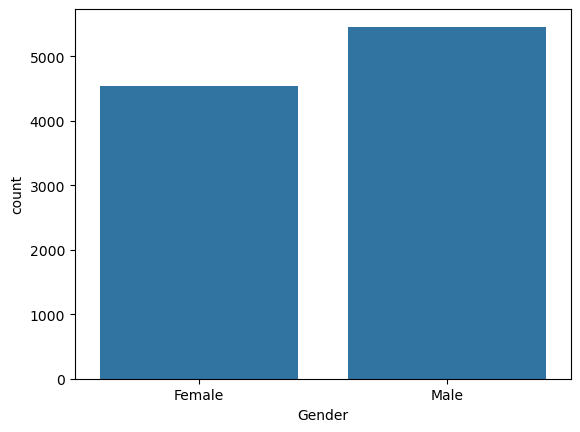

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import scipy.stats as stats
path = r'D:\User\Data'
os.chdir(path)

# Importing data 
churn_data = pd.read_csv("churn.csv")
print(churn_data.info())
print(churn_data.describe())

#Plotting gender counts
print(churn_data['Gender'].value_counts())
sns.countplot(x = 'Gender', data = churn_data)


In [3]:
# Checking for NA values
churn_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

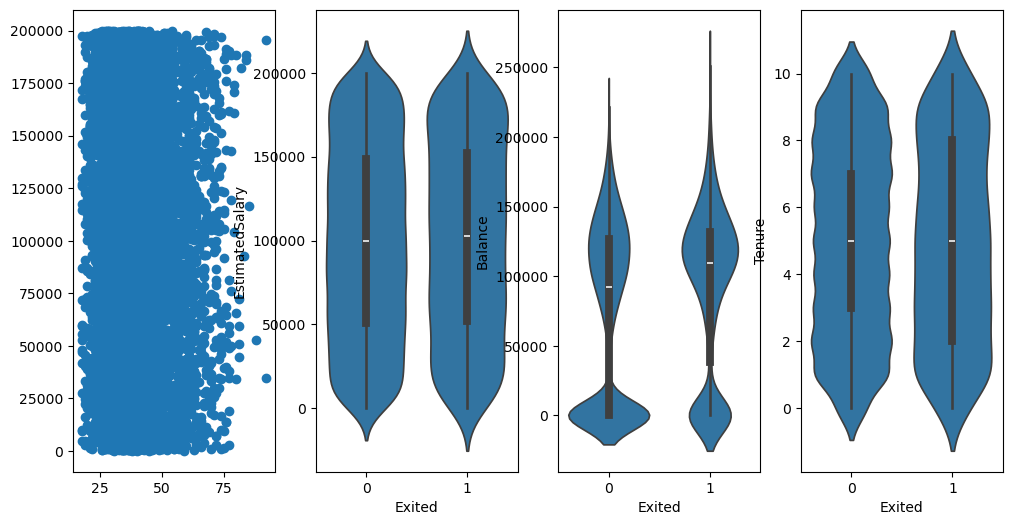

In [4]:
# Exploring relatioship of variables agianst exit status
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize =(12, 6))
ax1.scatter('Age','EstimatedSalary', data = churn_data)
sns.violinplot(data=churn_data, x = 'Exited', y = 'EstimatedSalary', ax=ax2)
sns.violinplot(data=churn_data, x = 'Exited', y = 'Balance', ax=ax3)
sns.violinplot(data=churn_data, x = 'Exited', y = 'Tenure', ax=ax4)
plt.show()

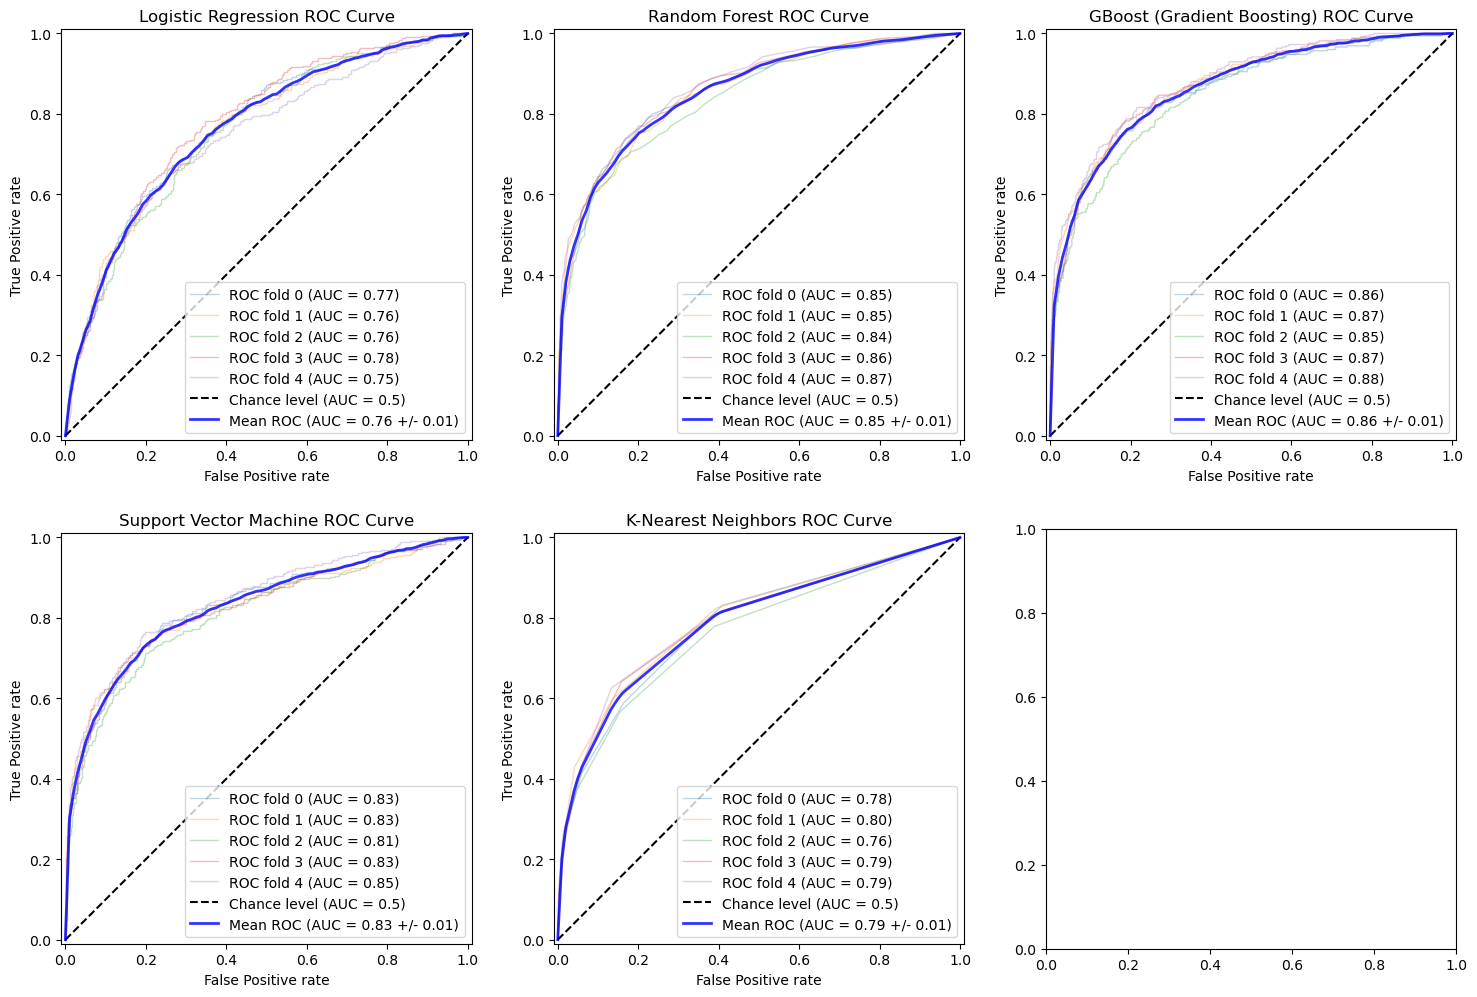

In [5]:
# Training 5 models and checing their performance with ROC curves
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


# Splitting predictor and target variables
predictors = churn_data.drop(['Exited', 'CustomerId', 'Surname', 'RowNumber'], axis=1)
target = churn_data['Exited']

# Making trianing+Validation and Test set
X_trainval, X_test, y_trainval, y_test = train_test_split(predictors, target, test_size=0.2, random_state=42, stratify=target)


# Identifying nurmeric and categorical columns
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember']
categorical_cols = ['Geography', 'Gender']

# Scaling numeric and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# dictionary of all the models
models_dict = { 'Logistic Regression':LogisticRegression(),'Random Forest': RandomForestClassifier(random_state=42),
                'GBoost (Gradient Boosting)': GradientBoostingClassifier(random_state=42),'Support Vector Machine': SVC(),
                'K-Nearest Neighbors': KNeighborsClassifier()}


    
# cross validation 
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)


# compare models 
uniform_fpr = np.linspace(0,1,100)


fig, ax = plt.subplots(2,3,  figsize=(18, 12))
ax_flat = ax.flatten()

# Color cycle for folds
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
curve_kwargs_list = [
    dict(alpha=0.3, lw=1, color=colors[fold % len(colors)]) for fold in range(n_splits)
]

names = [f'ROC fold {i}' for i in range(n_splits)]

for i, (model_name, model) in enumerate(models_dict.items()):
    pipe = make_pipeline(preprocessor, model)


    #cross validation scores
    cv_scores = cross_validate(pipe, X_trainval, y_trainval, cv=skf, return_estimator=True, return_indices=True)
    viz = RocCurveDisplay.from_cv_results(cv_scores, X_trainval, y_trainval, ax=ax_flat[i], name=names, plot_chance_level = True, curve_kwargs=curve_kwargs_list)

    # Interpolate TPRs to common FPR grid
    interp_tprs = []
    for j in range(n_splits):
        interp_tpr = np.interp(uniform_fpr, viz.fpr[j], viz.tpr[j])
        interp_tpr[0] = 0.0
        interp_tprs.append(interp_tpr)

    # calculating mean and std for the mean ROC curve
    mean_tpr = np.mean(interp_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(uniform_fpr, mean_tpr)
    std_auc = np.std(viz.roc_auc)

    # Plot the mean ROC curve
    ax_flat[i].plot(uniform_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {round(mean_auc,2)} +/- {round(std_auc,2)})', lw=2, alpha=0.8)
    ax_flat[i].legend(loc="lower right")

    # Customising subplot
    ax_flat[i].set(xlabel='False Positive rate', ylabel='True Positive rate', title=f'{model_name} ROC Curve')
    
    
        



In [6]:
# Using Random search to determine the best hyperparameters, if processing power allows however, then a Gridsearch is recommended
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

##performing hyperparameter tuning with random search on our top models

# Gradient Boost
# setting parameter testing dictionary
GB_params = {'gradientboostingclassifier__n_estimators': [50, 100, 200],
              'gradientboostingclassifier__learning_rate':[0.05,0.1,0.3,0.5],
              'gradientboostingclassifier__max_depth':[2,3,5,7],
              'gradientboostingclassifier__min_samples_split': [2,5,10],
              'gradientboostingclassifier__min_samples_leaf': [1,2,4]}

# performing random search
pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state=9))
rand_search_XG = RandomizedSearchCV(pipe, param_distributions=GB_params, n_iter=40, scoring='roc_auc', cv=5, random_state=9, n_jobs=3, refit='roc_auc')
rand_search_XG.fit(X_trainval, y_trainval)
print(rand_search_XG.best_params_)
print(rand_search_XG.best_score_)



# Random Forest
# setting parameters for random search
rf_params = {'randomforestclassifier__n_estimators': [100, 200, 300],
                 'randomforestclassifier__max_depth': [None, 10, 20, 30],
                 'randomforestclassifier__min_samples_split': [2, 5, 10],
                 'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                 'randomforestclassifier__max_features': ['sqrt', 'log2', None]}

#performing random search
pipe = make_pipeline(preprocessor, RandomForestClassifier())
rand_search_rf = RandomizedSearchCV(pipe, param_distributions=rf_params, n_iter=40, scoring='roc_auc', cv=5, random_state=9, n_jobs=3, refit='roc_auc')
rand_search_rf.fit(X_trainval,y_trainval)
print(rand_search_rf.best_params_)
print(rand_search_rf.best_score_)


{'gradientboostingclassifier__n_estimators': 50, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__learning_rate': 0.1}
0.8643940634299968
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_depth': 10}
0.8634791151005


In [7]:
# Trianing models with optimal hyperparameters
models_dict = {
    'Gradient Boosting': {
        'pipeline': make_pipeline(preprocessor, GradientBoostingClassifier(random_state=42)),
        'params': {
            'gradientboostingclassifier__n_estimators': 50,
            'gradientboostingclassifier__min_samples_split': 2,
            'gradientboostingclassifier__min_samples_leaf': 1,
            'gradientboostingclassifier__max_depth': 5,
            'gradientboostingclassifier__learning_rate': 0.1
        }
    },
    'Random Forest': {
        'pipeline': make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
        'params': {
            'randomforestclassifier__n_estimators': 200,
            'randomforestclassifier__max_depth': 10,
            'randomforestclassifier__min_samples_split': 10,
            'randomforestclassifier__min_samples_leaf': 4,
            'randomforestclassifier__max_features': 'log2'
        }
    }
}

results = {}

for name, model_info in models_dict.items():
    pipe = model_info['pipeline']
    pipe.set_params(**model_info['params'])
    
    # Train
    pipe.fit(X_trainval, y_trainval)
    y_pred = pipe.predict(X_test)
    
    # Some models (like SVC) need probability=True to use predict_proba
    if hasattr(pipe[-1], "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    else:
        y_proba = None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-score': f1,
        'ROC-AUC': roc
    }

# Convert to DataFrame
results_df = pd.DataFrame(results).T
results_df = results_df.round(3)
print(results_df)

                   Accuracy  Precision  Recall  F1-score  ROC-AUC
Gradient Boosting     0.870      0.808   0.474     0.598    0.870
Random Forest         0.868      0.818   0.452     0.582    0.862


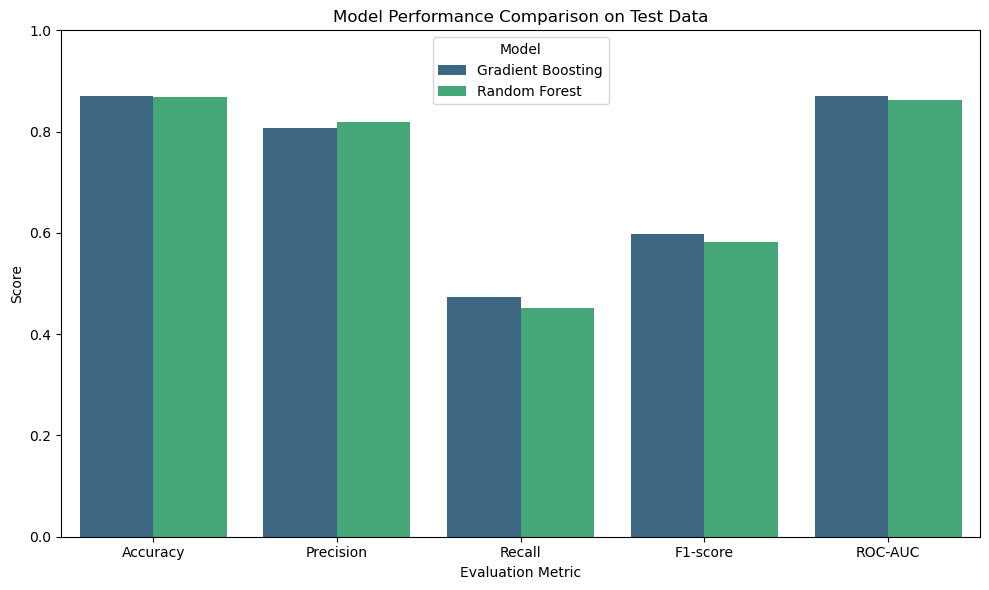

In [8]:
# Plotting accuracy, precision, recall, ROC and f-1 scores on a bar chart for comparison
# Plotting results
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score'),
            x='Metric', y='Score', hue='index', palette='viridis')
plt.title('Model Performance Comparison on Test Data')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

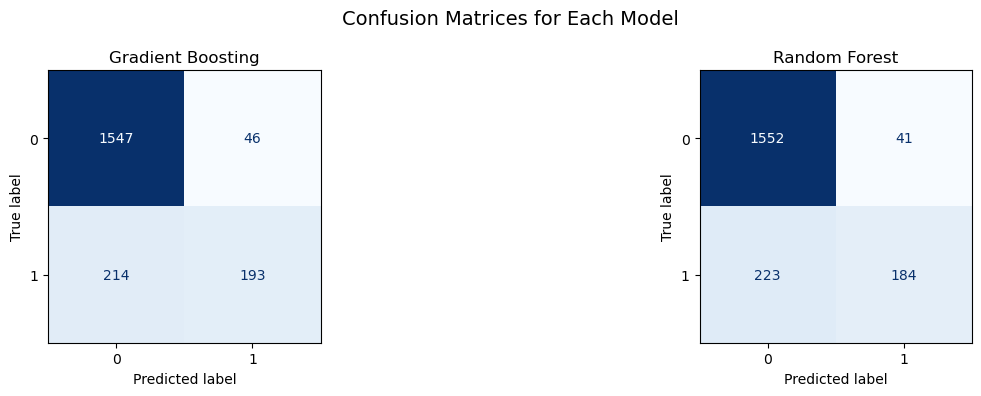

In [9]:
# Confusion matrices of all models
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(15, 4))

for ax, (name, model_info) in zip(axes, models_dict.items()):
    pipe = model_info['pipeline']
    pipe.set_params(**model_info['params'])
    pipe.fit(X_trainval, y_trainval)
    y_pred = pipe.predict(X_test)
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(name)

plt.suptitle("Confusion Matrices for Each Model", fontsize=14)
plt.tight_layout()
plt.show()

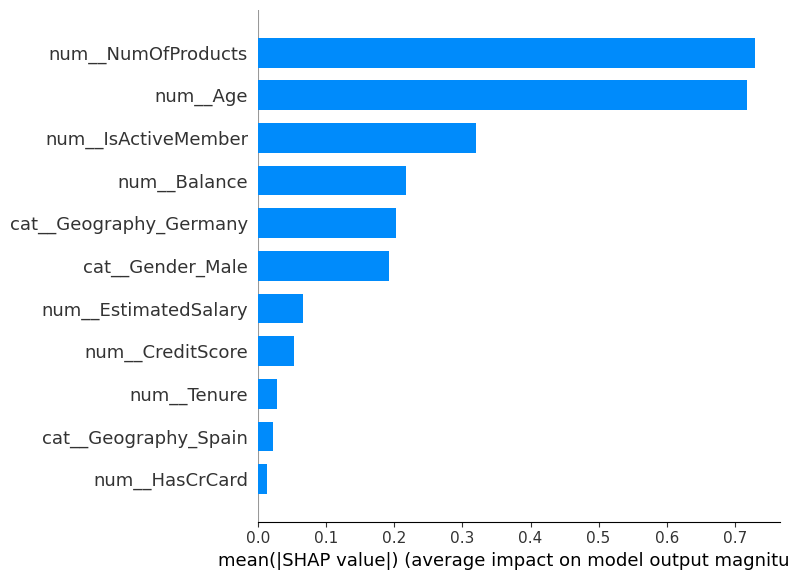

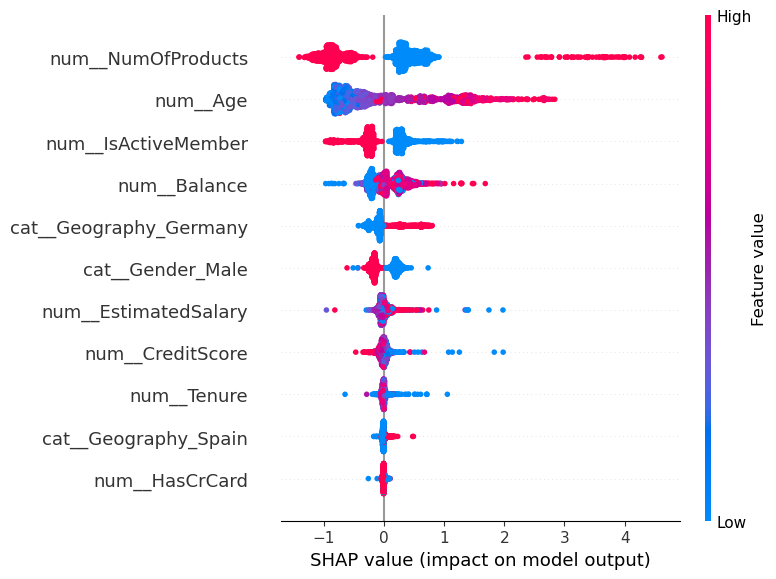

In [10]:
# Assessing which features affect customer exit the most
#pip install shap might be required 
import shap

# Get trained pipeline
best_model = models_dict['Gradient Boosting']['pipeline']
best_model.fit(X_trainval, y_trainval)

# Extract the trained classifier and preprocessor
gb_model = best_model.named_steps['gradientboostingclassifier']
preprocessor = best_model.named_steps['columntransformer']

# Transform test data using the same preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Get feature names after transformation
feature_names = preprocessor.get_feature_names_out()

# Create a DataFrame for readability
X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# Create SHAP explainer for the *classifier only*, not the full pipeline
explainer = shap.Explainer(gb_model)

# Compute SHAP values
shap_values = explainer(X_test_df)

# Summary bar plot of most important features
shap.summary_plot(shap_values, X_test_df, plot_type="bar")

# Detailed summary (beeswarm)
shap.summary_plot(shap_values, X_test_df)
